# Wind Speed Time Series

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import pickle
import time
import datetime
from salishsea_tools import viz_tools, geo_tools, grid_tools, utilities # likely some reduendant import stements here
%matplotlib inline

In [3]:
# loading the wind data from the ERDDAP server
winddata = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1")
# we will use these time values to provide the time values for our timeseries
wind_times = winddata.time.values.astype('datetime64[s]').astype(datetime.datetime)

### Extract timeseries from dictionary pickle files. No need to do this agian, the files are picked:

In [4]:
# since I had pickled the wind speeds for the wind speed climatology maps I produced at first, what I needed to do here
# was to get a time series for each of the locations were selected for the initial oil spill storytelling

# set up the variables needed to loop over the data points and create the output file names
years = [2015,2016,2017,2018]
abbrs = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
# these are the names to give to the output time series pickle files 
locs = ['salmon' ,'turn', 'sog']
# these are the corrsponding indices (y,x) i.e. python is row-major like C and MATLAB, and indices are zero-based, obtained from "Pick grid points.ipynb"
loc_coords = [(99, 159),(116, 150),(143, 141)]


for year in years:
    # load the wind speed across the domain for the year form the file 
    filename = "/home/abhudia/Desktop/Wind speed/y{}_data.pickle".format(str(year))
    loader = open(filename, "rb")
    wind_year = pickle.load(loader)
    # not sure why i needed to create local variables, these could have been done with old schoool variables
    locals()['salmon'] = np.array([])
    locals()['turn'] = np.array([])
    locals()['sog'] = np.array([])
    # since the loaded pickle data is in dictionary format i.e. stored by each month:
    for abbr in abbrs:
        for index in range(3):
            # append the wind records for each location to their respective arrays
            locals()[locs[index]] = np.append(locals()[locs[index]],wind_year[abbr + '_data'].isel(gridY = loc_coords[index][0],gridX = loc_coords[index][1]).values)
    # save each of the timeseries as pickle files
    for index in range(3):
        fname = "winds_{}{}.pickle".format(locs[index], year)
        picklefile = open(fname, 'wb')
        pickle.dump(locals()[locs[index]], picklefile)
        picklefile.close()
        locals()[locs[index]] = False


## Make Timeseries For Each Point

In [10]:
# what I do here is a little weird
# since i'm not using functions to generate the plots, I am just creating variables in loops
locs = ['salmon' ,'turn', 'sog']
for year in [2015, 2016, 2017, 2018]:
    for loc in locs:
        # loading the pickle file at the location for that year
        fname = "winds_{}{}.pickle".format(loc, str(year))
        file = open(fname, "rb") 
        locals()["winds_{}".format(loc) + str(year)] = pickle.load(file)
        locals()["t_{}".format(loc) + str(year)] = []
        # getting the times that correspond to the data from the times we obtained above from the Errdap data
        for time in wind_times: 
            if time.year == year:
                locals()["t_{}".format(loc) + str(year)].append(time)
# the result, for example from the first loop, is that I create two variables, t_2015 and winds_salmon2015

# it is a strange way to do it but it was faster

# Make Plots

In [11]:
def average_output(data_array, times, period):
    """Produce the average of a one diensional array by the perios indicated eg seconds, hours, months, days
       arg data_array: 1D array
       arg times: list of times corresponding to data
       arg period: string, one of [s, m, d,... etc] eg d to indicate that you want the by day average
       
       return list [listofUnique_times, listof_mean_by_unique_time_period]
    """
    # the unique times in the period selected e.g. the unique days, and the count of the occurences of each unique day
    unique, counts = np.unique(np.asarray(times).astype('datetime64[{}]'.format(period)).astype(datetime.datetime), return_counts=True)
    
    count_so_far = 0; means = []
    
    # counts is a list of unique occurences e.g. [24,24,24....]
    # so if we want to make slices, we want the cumulative sum so far and the cumsum plus how many occurences we have
    # when we average the slices, we can ge tht average by unique time period
    for count in counts:
        means.append(np.sum(data_array[count_so_far: count_so_far + count])/count)
        count_so_far = count_so_far + count
        
    return([unique, means])  

In [12]:
def std_dev_output(data_array, times, period):
    """In a similar manner to the function above, slice the data butthis time, return the standard deviation of the data in each slice
       arg data_array: 1D array
       arg times: list of times corresponding to data
       arg period: string, one of [s, m, d,... etc] eg d to indicate that you want the by day average
       
       return list [listofUnique_times, listof_stddev_by_unique_time_period]
    """
    unique, counts = np.unique(np.asarray(times).astype('datetime64[{}]'.format(period)).astype(datetime.datetime), return_counts=True) 
    index = 0; count_so_far = 0; std_devs = []
    for count in counts:
        std_devs.append(np.std(data_array[count_so_far: count_so_far + count], ddof =1))
        count_so_far = count_so_far + count
        
    return([unique, std_devs]) 
    

In [13]:
# this is some code i used to test the behavior of the above code
a = np.array([1,2,3,4,5,6])
b = [1,2,3]
count_so_far = 0
means = []
for count in b:
    means.append(np.sum(a[count_so_far: count_so_far + count])/count)
    count_so_far = count_so_far + count


In [14]:
def running_mean(x, N):
    """return the rumnning mean of data from a 1D array with a running mean window width of N
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

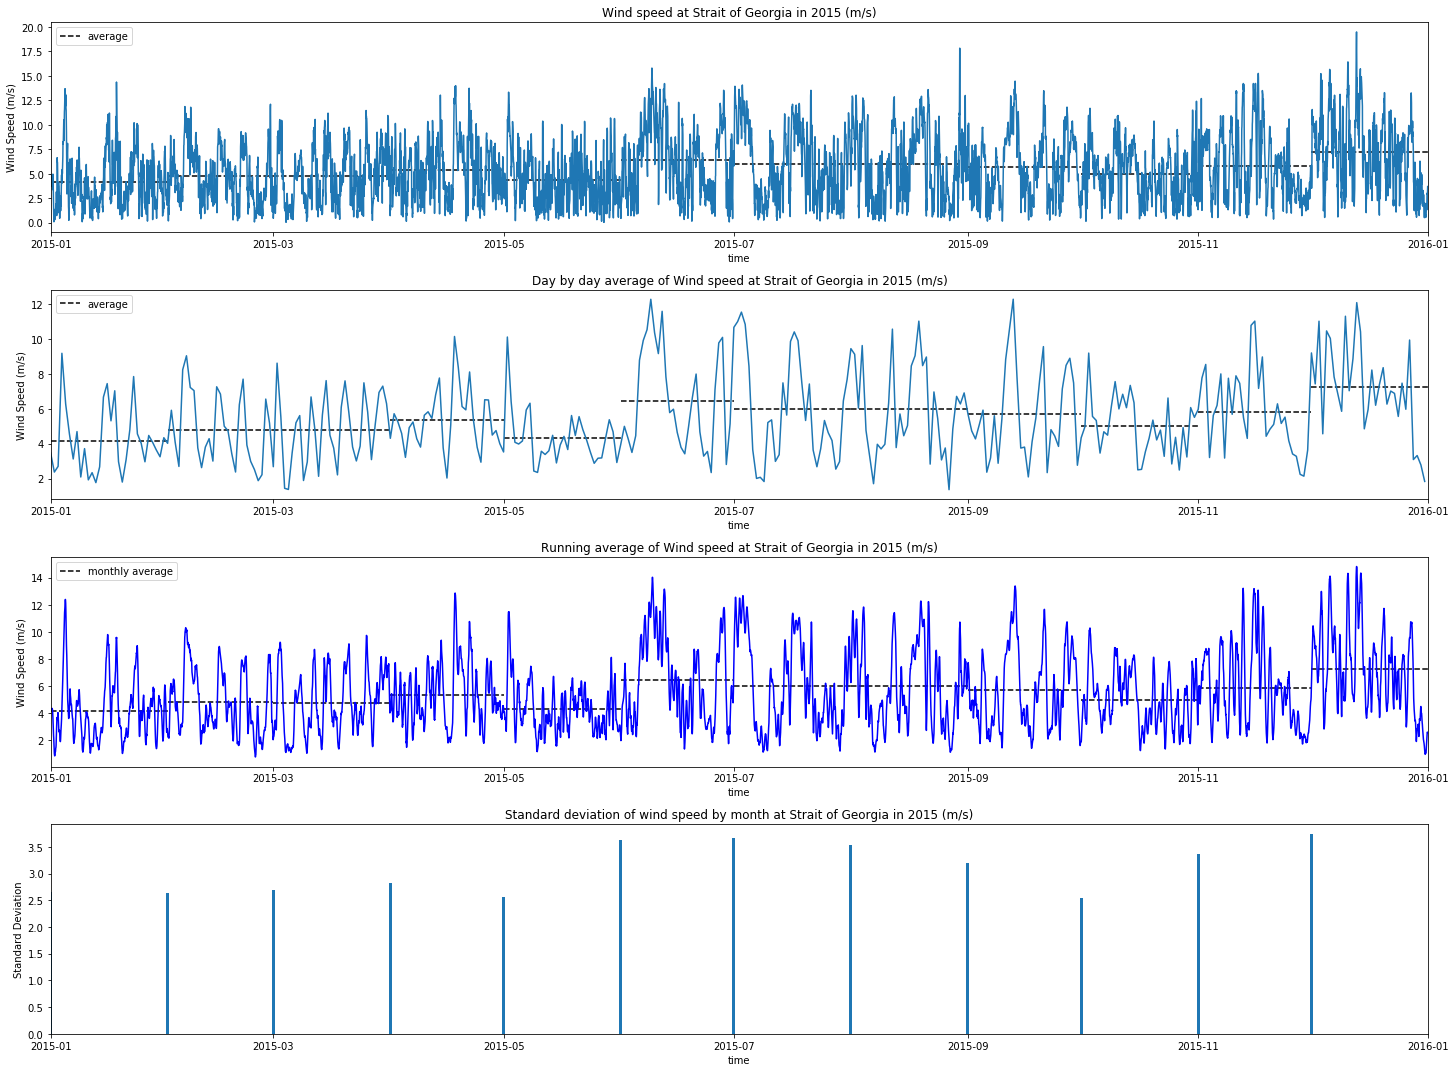

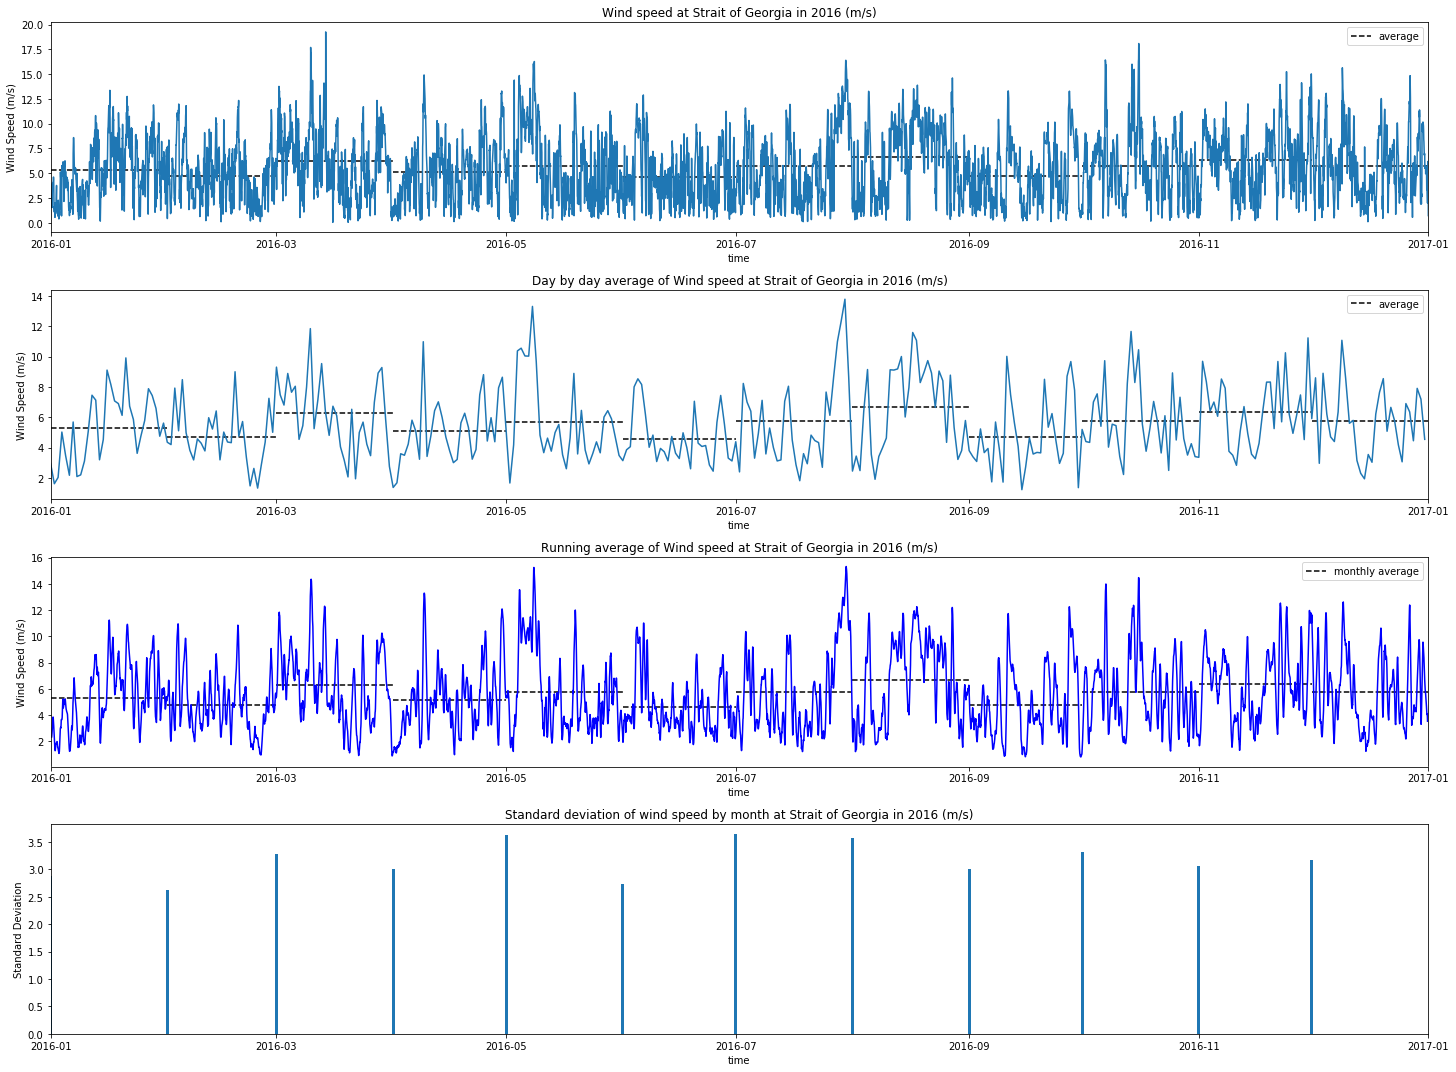

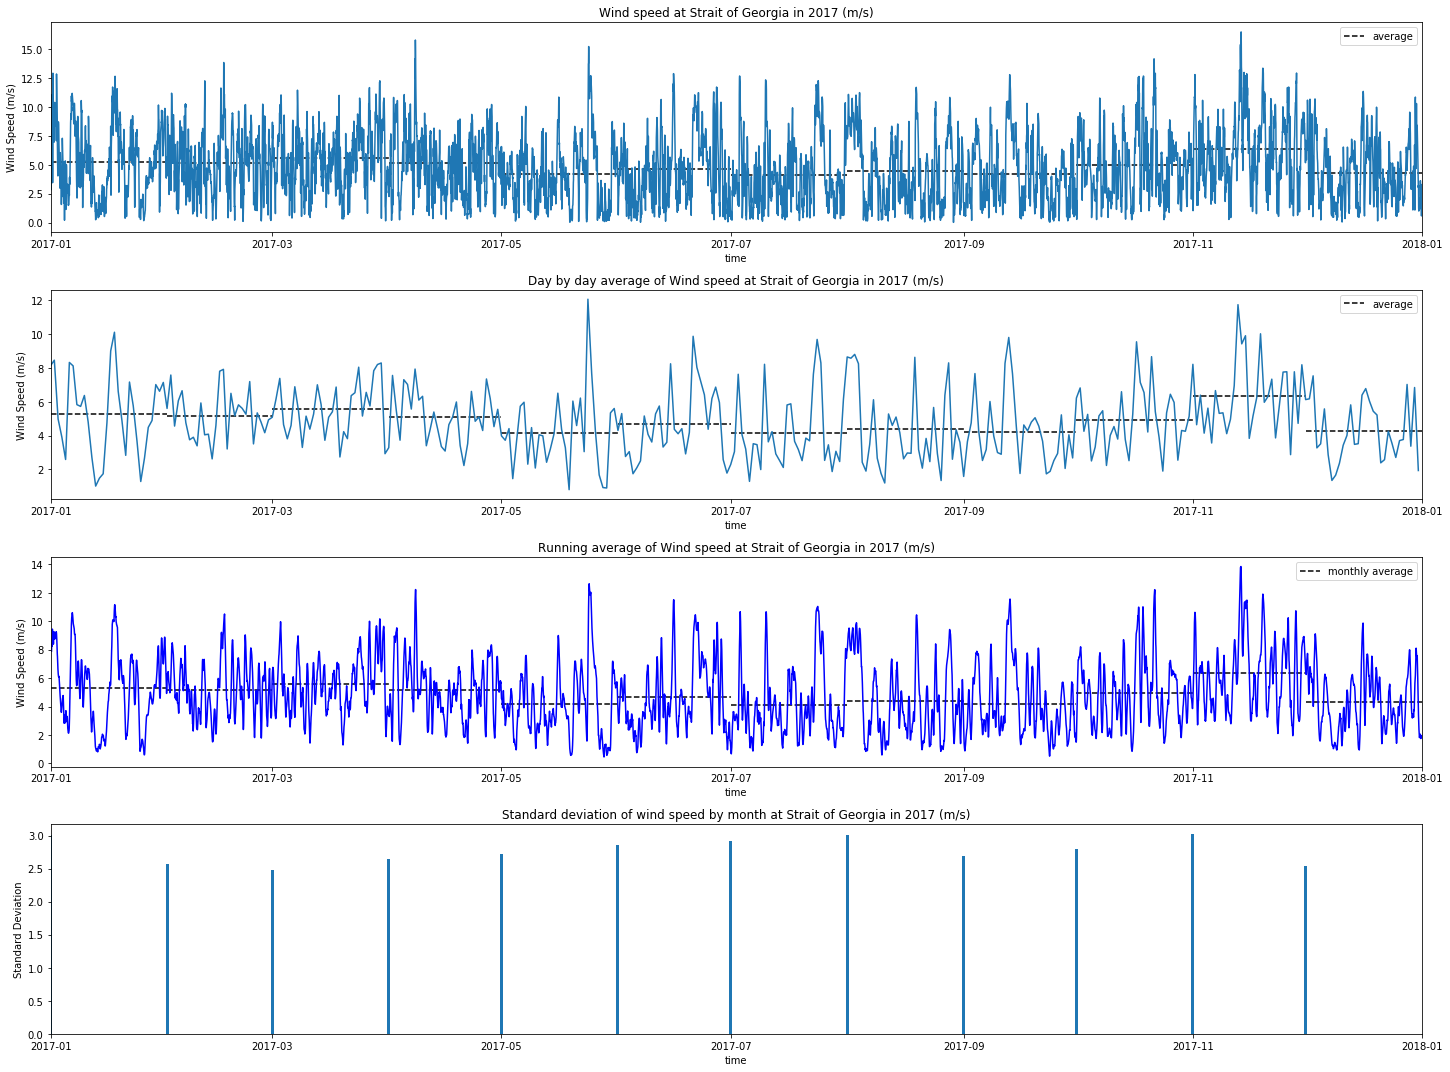

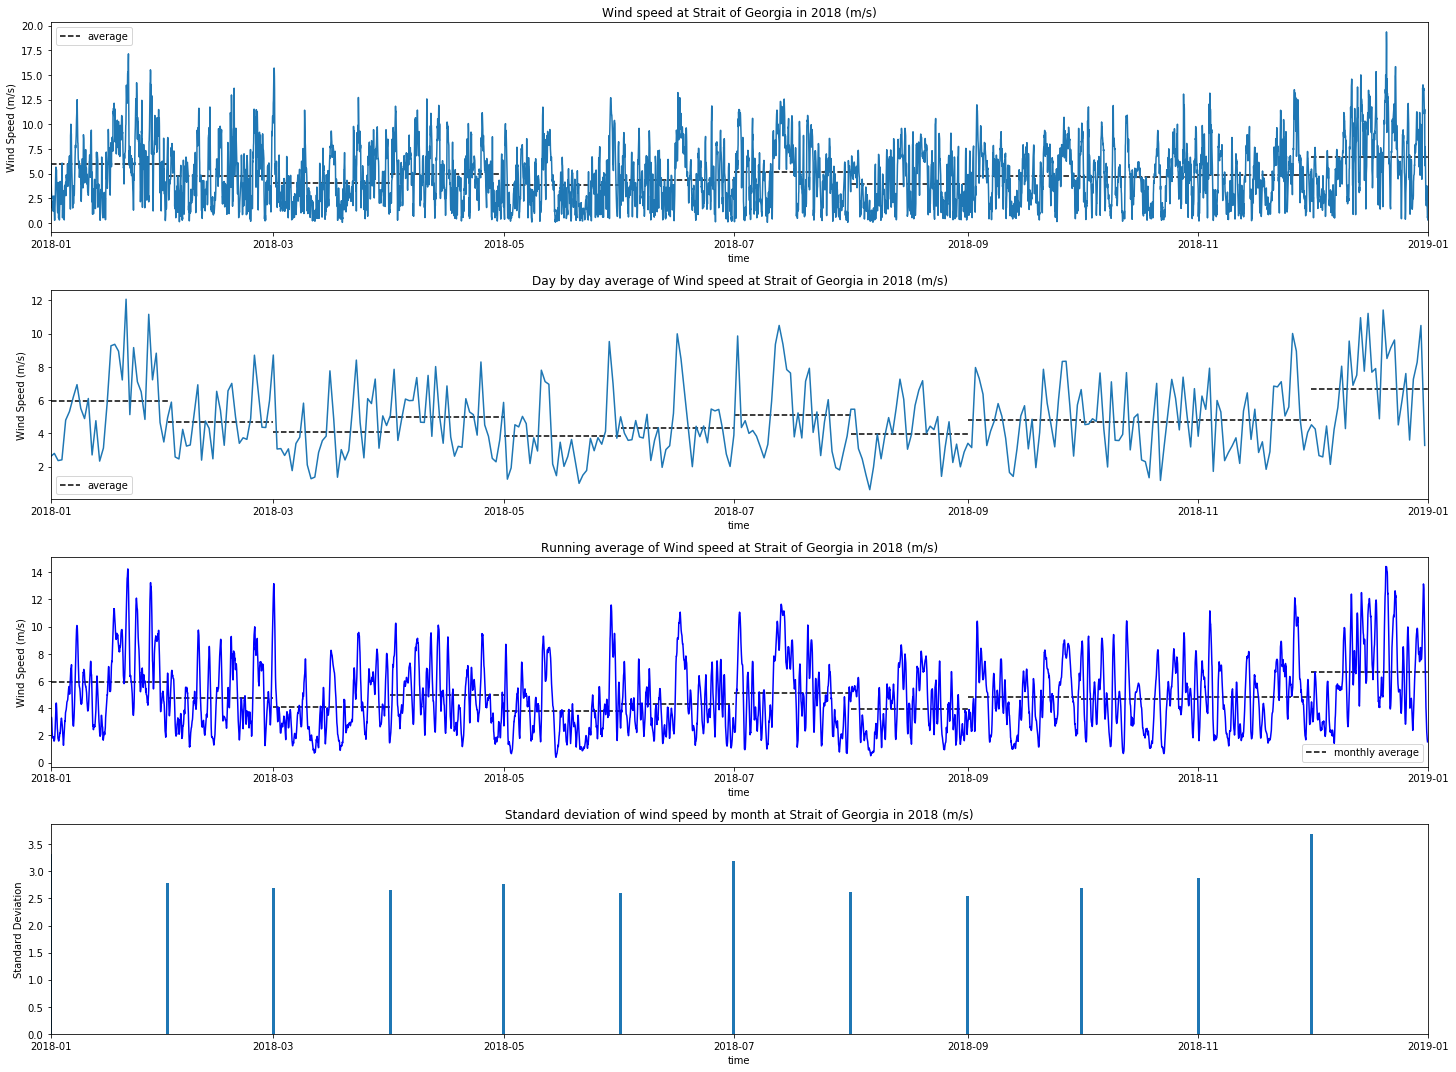

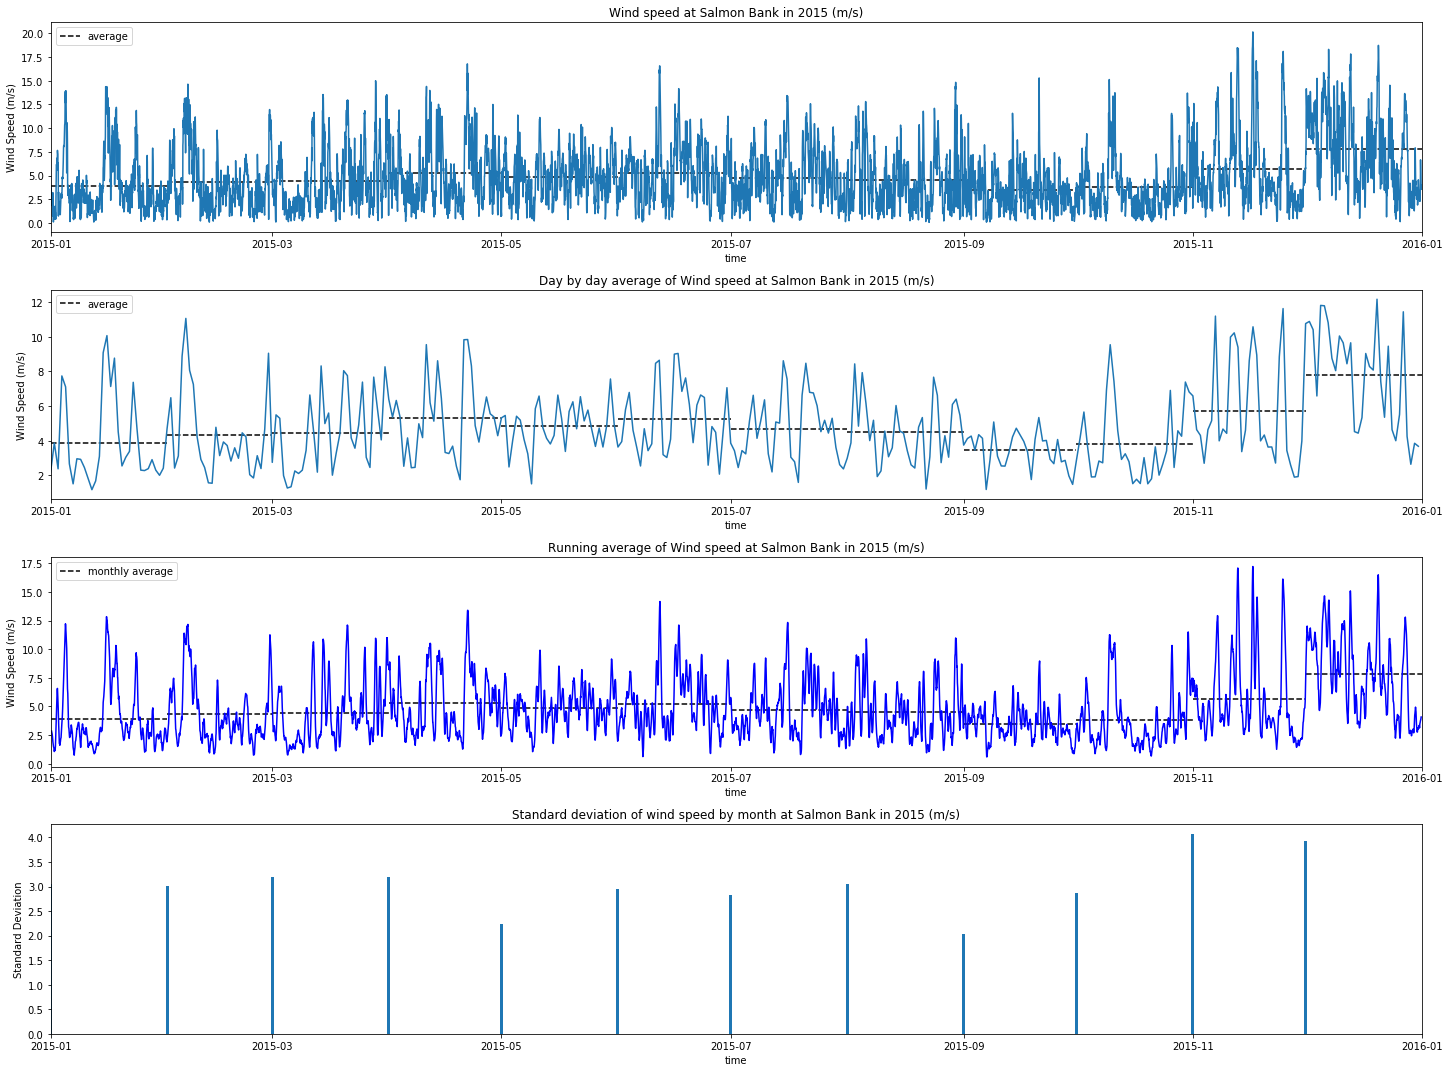

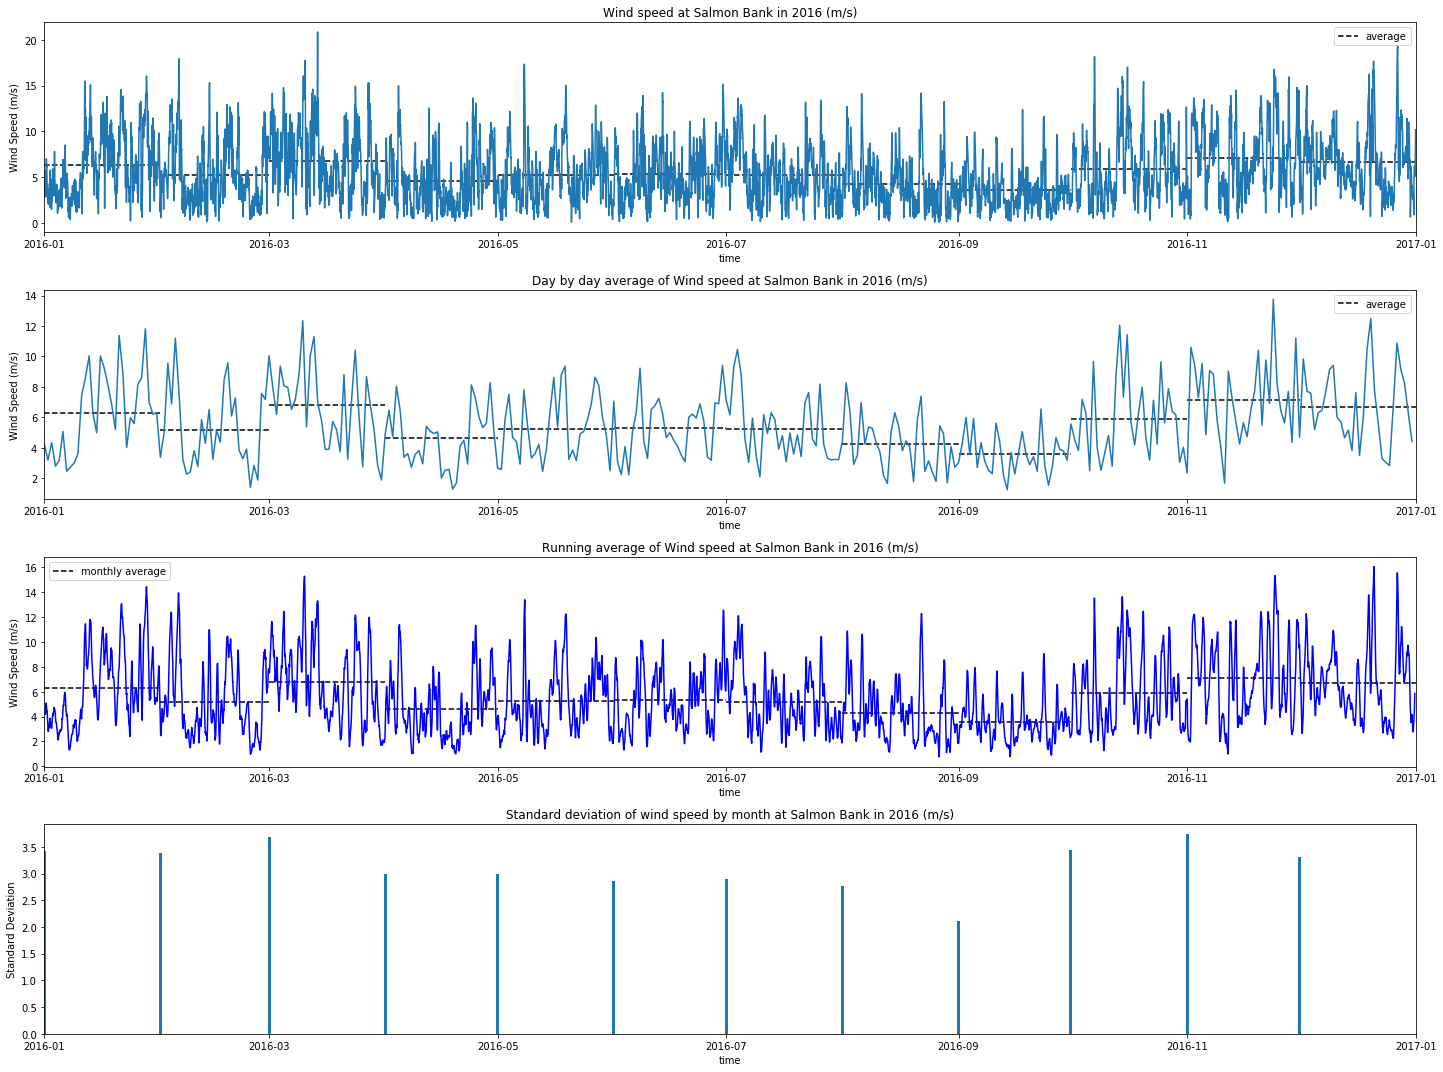

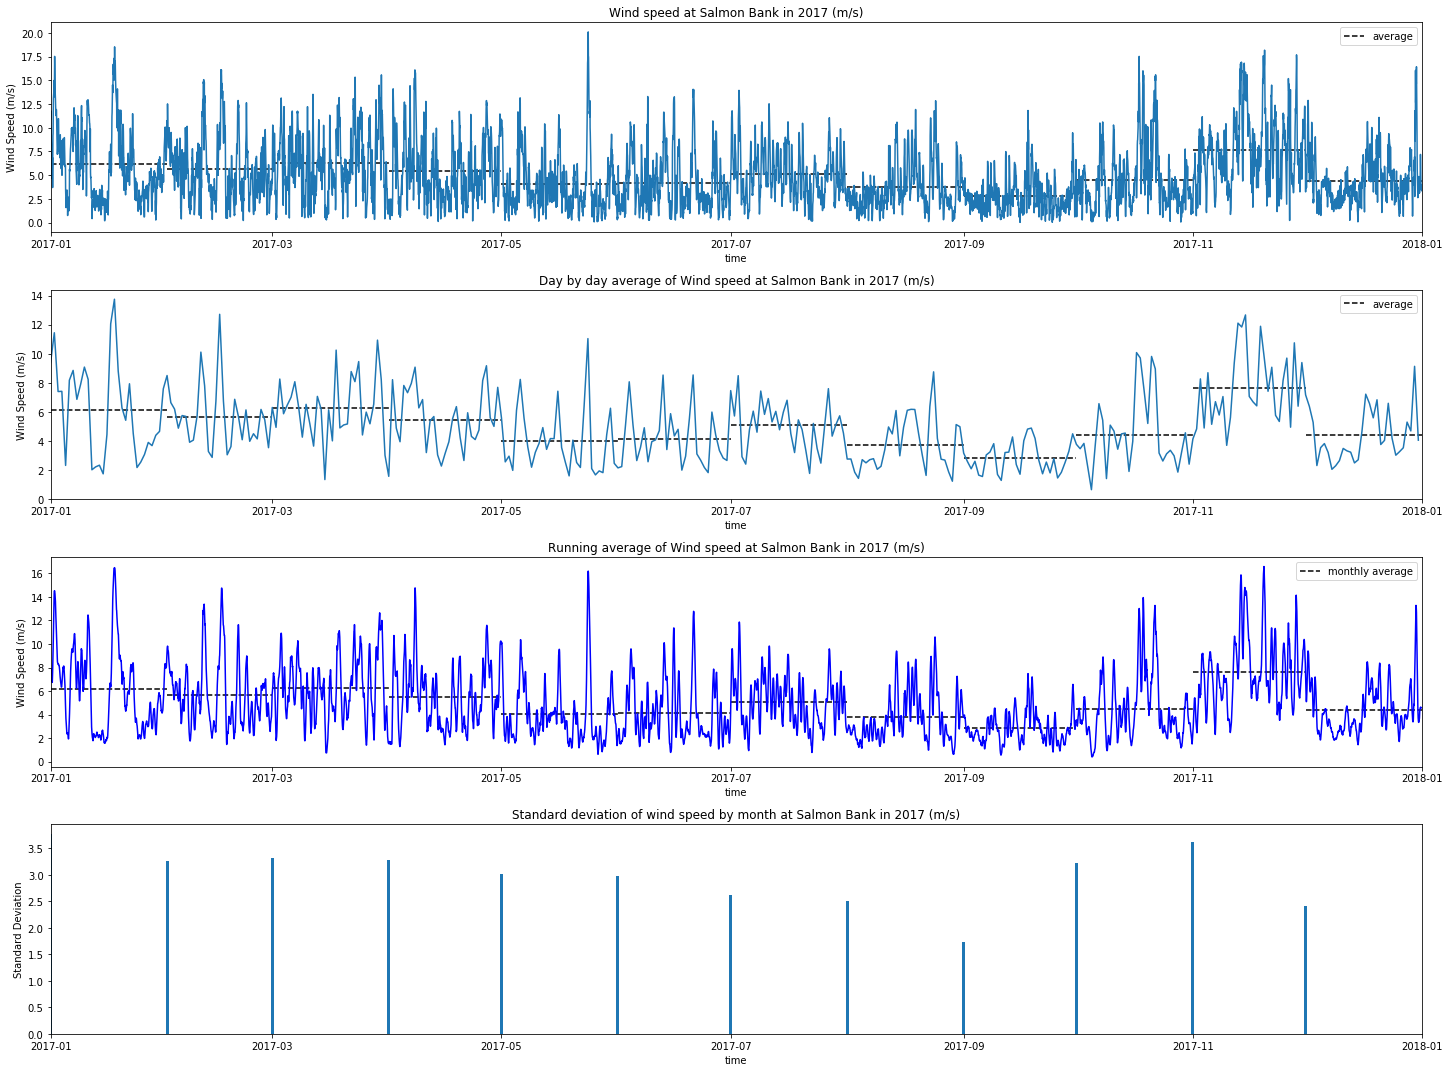

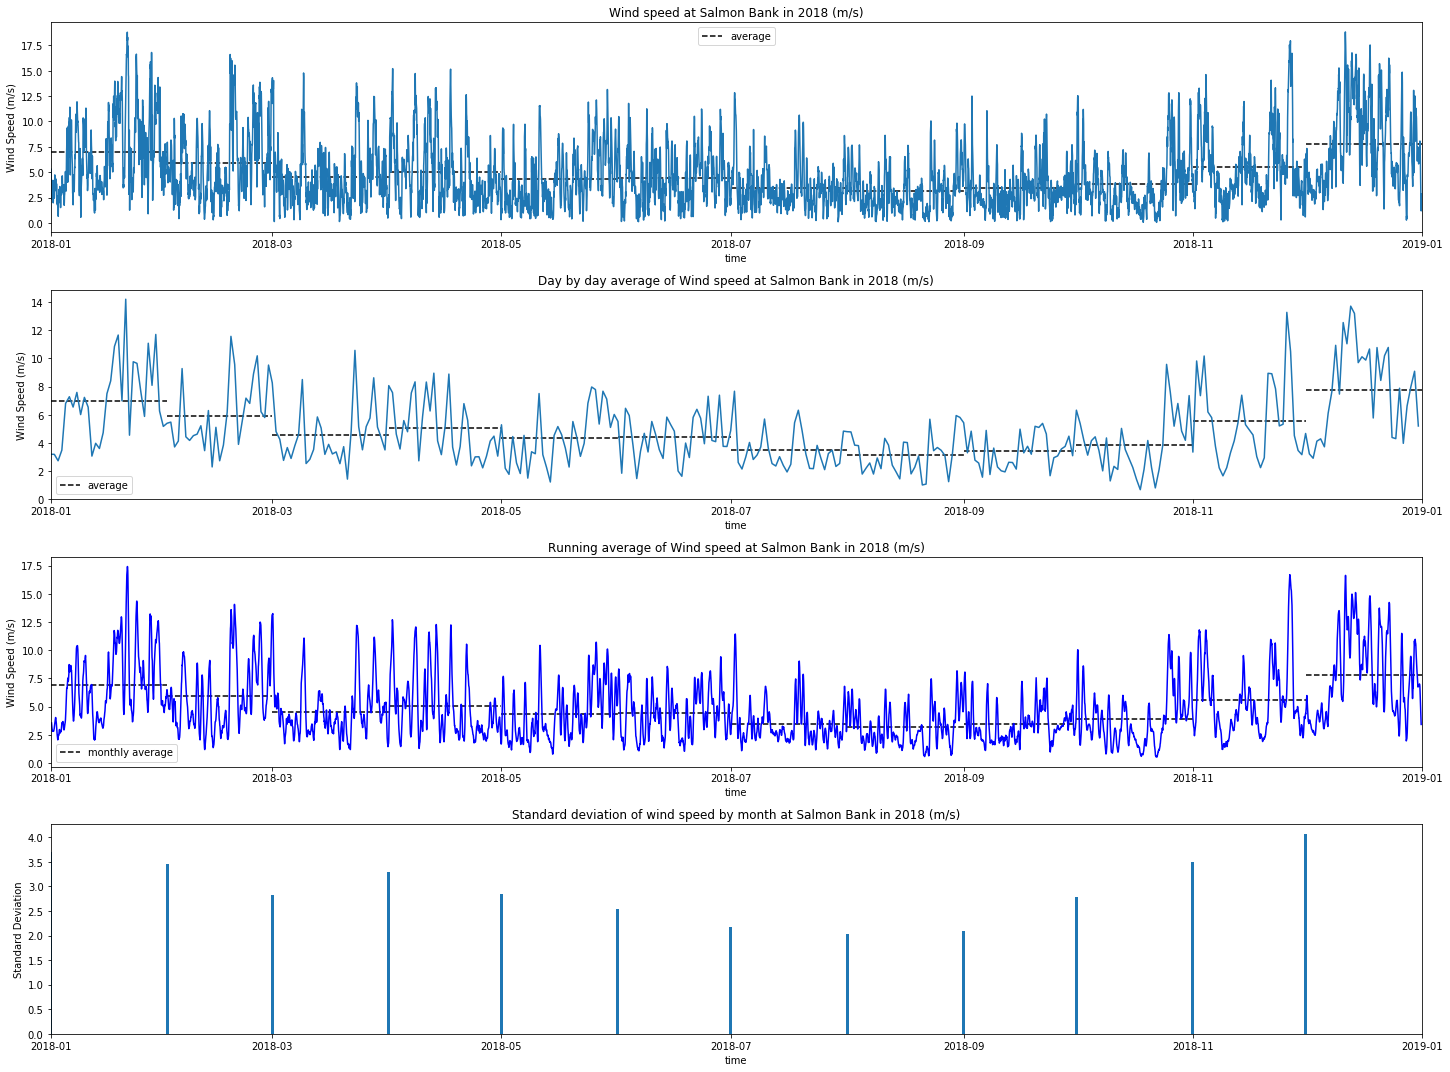

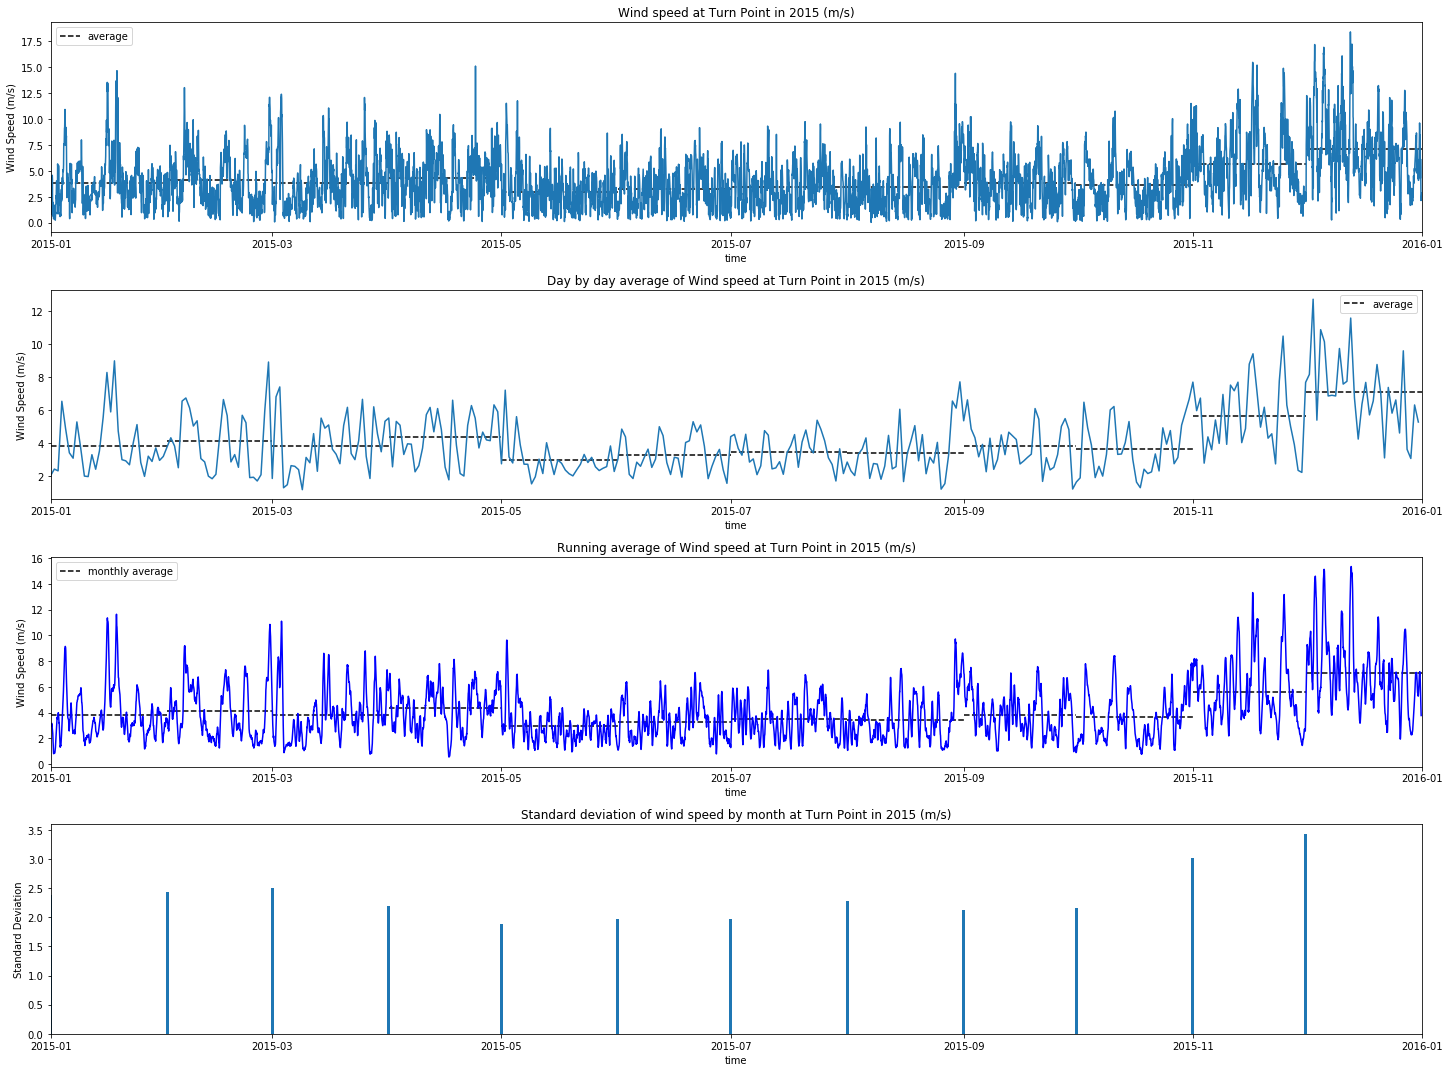

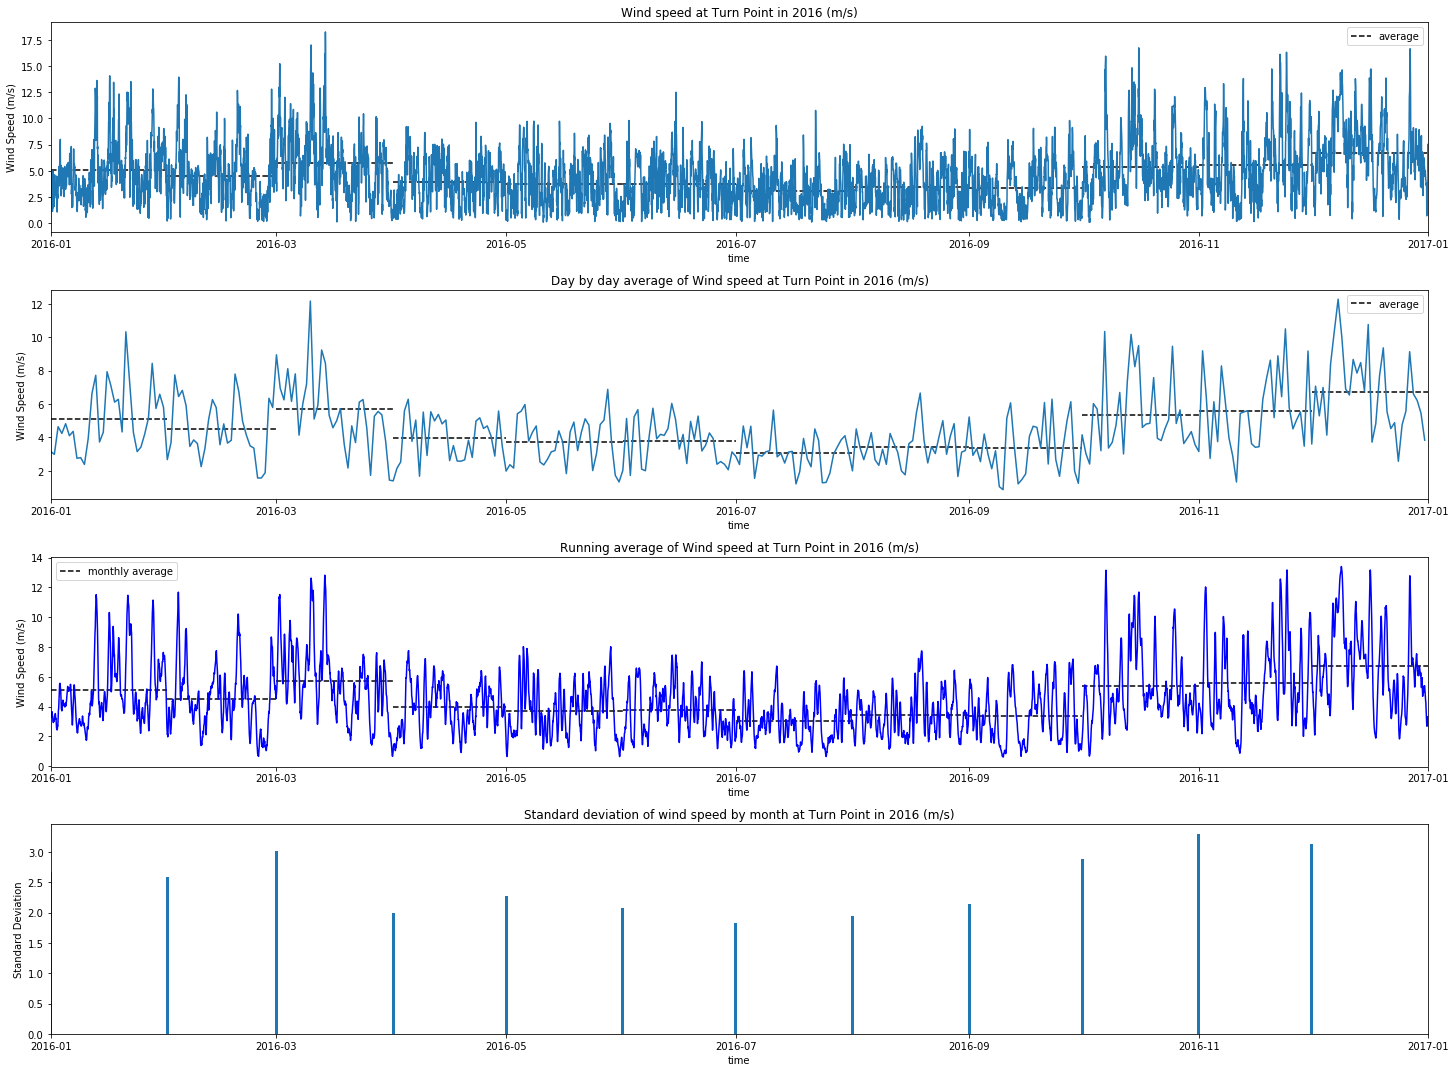

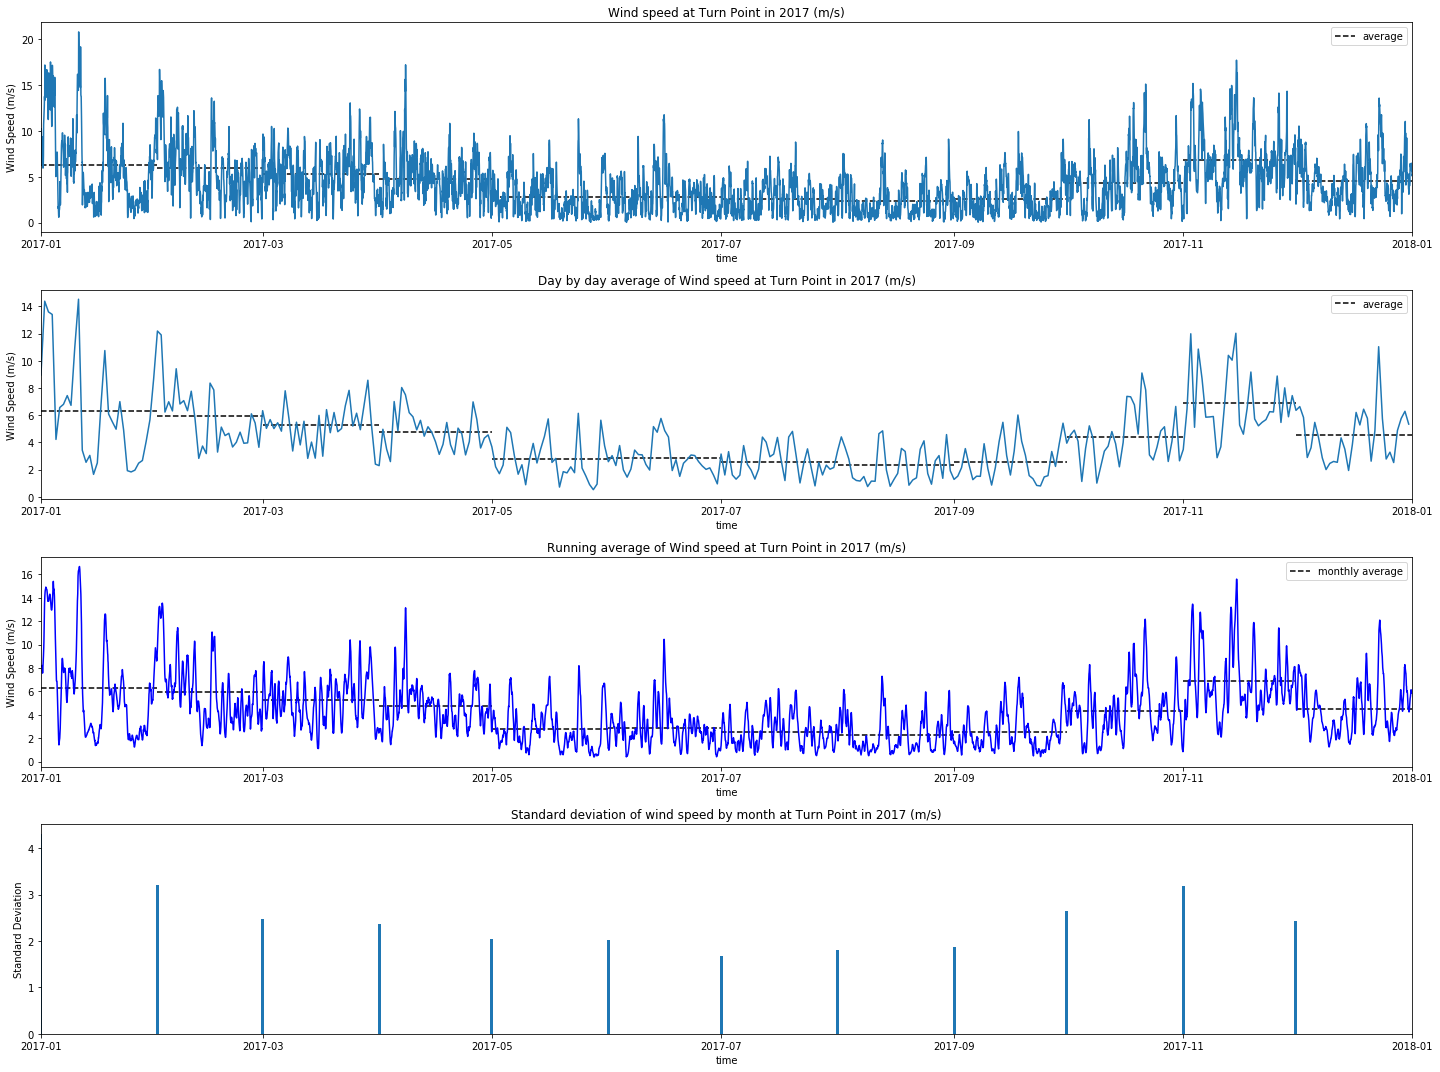

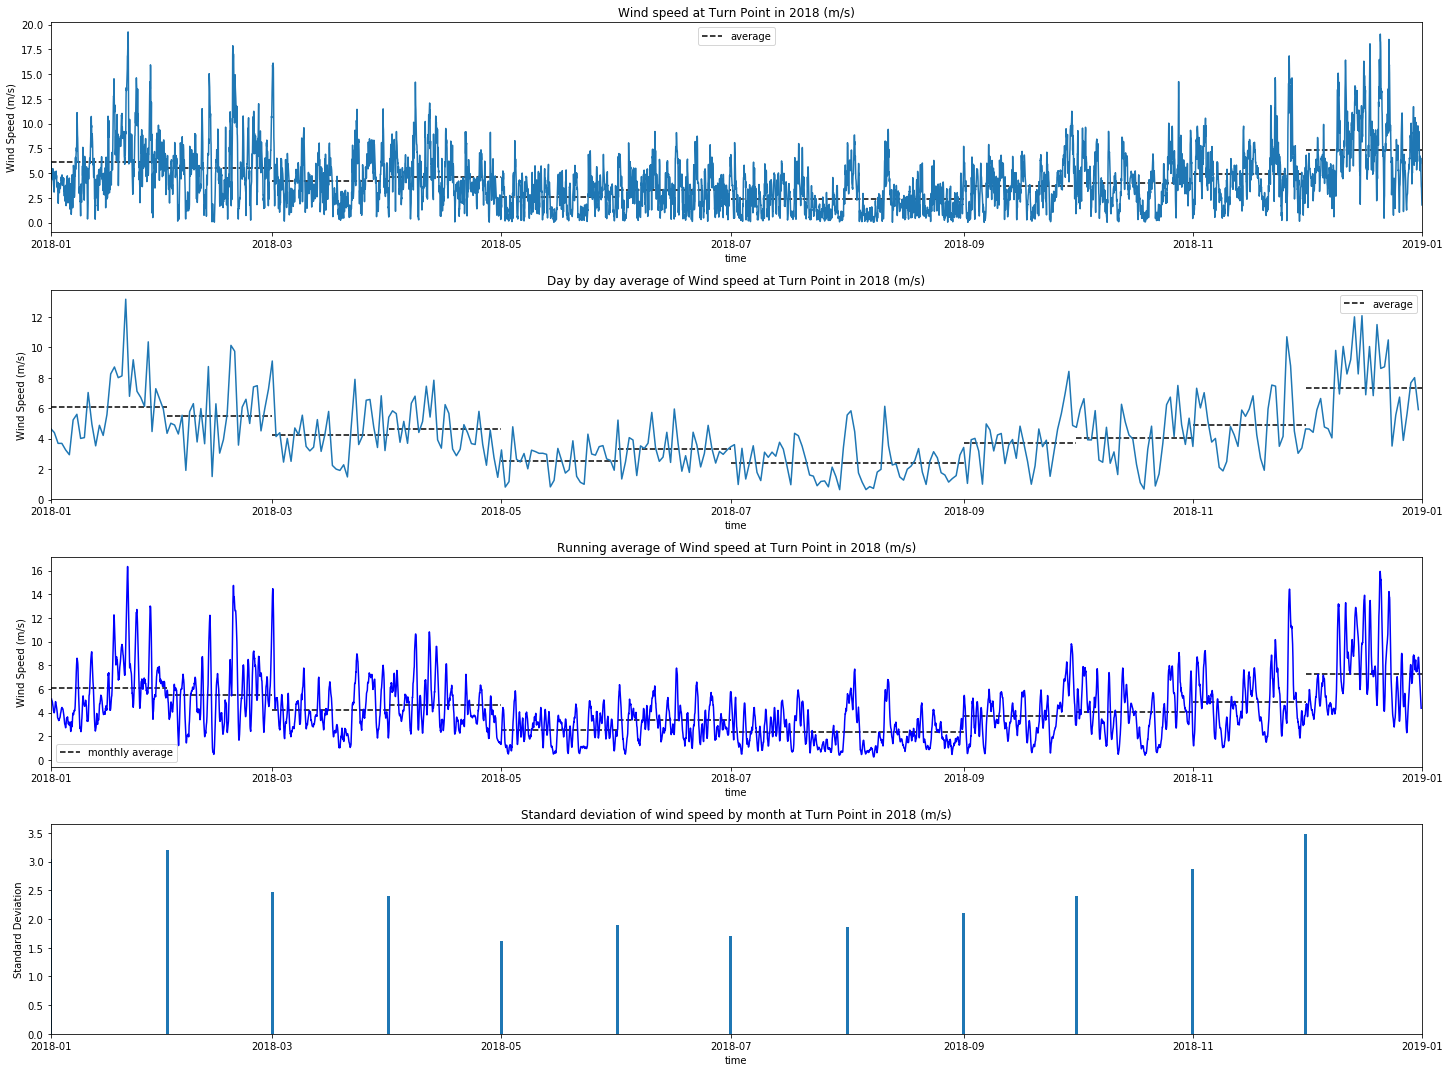

In [18]:
locs = ['sog', 'salmon', 'turn']
locations = ['Strait of Georgia', 'Salmon Bank', 'Turn Point']
years = [2015,2016,2017,2018] 
N = 12 # windows form running mean
for index in range(3):
    # we are going location by location
    
    # these lists here will be used to output a csv file containing the statistics
    all_times = []
    all_means = []
    all_std = []
    
    # now we will loop through the daya by year
    for year in years: 
        # these strings are the variables names that we want to deal with
        wind_array = "winds_{}{}".format(locs[index], str(year))
        times = "t_{}{}".format(locs[index], str(year))
        # use the locals call to access the variables created above. get the mean of the data by month
        mean_month = average_output(locals()[wind_array],locals()[times], 'M')[1]
        
        # set up the plot figure area
        fig = plt.figure(figsize=(20,15))
        # we want to make four subplots with onecolumn and four rows
        ax1 = plt.subplot(4,1,1)
        # use the locals call to lot a raw timeseries of the wind data
        plt.plot(locals()[times], locals()[wind_array])
        plt.xlabel('time')
        plt.ylabel('Wind Speed (m/s)')
        # add verical lines to delinieate the different months
        for month in range(1, 13):
            if month != 12:
                plt.hlines(mean_month[month-1], xmin = datetime.datetime(year, month, 1, 0, 0 ,0),xmax =  datetime.datetime(year, month + 1, 1, 0, 0 ,0), linestyles = 'dashed')
            else:
                plt.hlines(mean_month[month-1], datetime.datetime(year, month, 1, 0, 0 ,0), datetime.datetime(year + 1 , 1, 1, 0, 0 ,0), linestyles = 'dashed', label = 'average')
                
        plt.legend()
        title = 'Wind speed at {} in {} (m/s)'.format(locations[index], year)
        plt.title(title)
        
        # second subplot
        ax2 = plt.subplot(4,1,2)
        # plot the daily averages
        data = average_output(locals()[wind_array],locals()[times], 'D')
        plt.plot(data[0], data[1])
        plt.xlabel('time')
        plt.ylabel('Wind Speed (m/s)')
        # vertical lines at beginning of each month
        for month in range(1, 13):
            if month != 12:
                plt.hlines(mean_month[month-1], xmin = datetime.datetime(year, month, 1, 0, 0 ,0),xmax =  datetime.datetime(year, month + 1, 1, 0, 0 ,0), linestyles = 'dashed')
            else:
                plt.hlines(mean_month[month-1], datetime.datetime(year, month, 1, 0, 0 ,0), datetime.datetime(year + 1 , 1, 1, 0, 0 ,0), linestyles = 'dashed', label = 'average')
        plt.legend()
        title = 'Day by day average of Wind speed at {} in {} (m/s)'.format(locations[index], year)
        plt.title(title)
        
        # third subplot
        ax3 = plt.subplot(4,1,3)
        # plot a running mean of time timeseries
        avg_values = running_mean(locals()[wind_array], N)
        avg_times = locals()[times][int(N/2): int(len(locals()[times]) - N/2 +1)]
        plt.plot(avg_times, avg_values, 'b-')
        plt.xlabel('time')
        plt.ylabel('Wind Speed (m/s)')
        # vertical lines at beginning of each month
        for month in range(1, 13):
            if month != 12:
                plt.hlines(mean_month[month-1], xmin = datetime.datetime(year, month, 1, 0, 0 ,0),xmax =  datetime.datetime(year, month + 1, 1, 0, 0 ,0), linestyles = 'dashed')
            else:
                plt.hlines(mean_month[month-1], datetime.datetime(year, month, 1, 0, 0 ,0), datetime.datetime(year + 1 , 1, 1, 0, 0 ,0), linestyles = 'dashed', label = 'monthly average')
        plt.legend()
        title = 'Running average of Wind speed at {} in {} (m/s)'.format(locations[index], year)
        plt.title(title)
        
        # fourth subplot
        ax4 = plt.subplot(4,1,4)
        # plot the standard deviation by each month
        std_devs = std_dev_output(locals()[wind_array],locals()[times], 'M')

        plt.bar(np.append(std_devs[0],np.array([datetime.datetime(year + 1, 1,1, 0, 0)])), np.append(np.asarray(std_devs[1]), np.array([0])))
        plt.xlabel('time')
        plt.ylabel('Standard Deviation')
        title = 'Standard deviation of wind speed by month at {} in {} (m/s)'.format(locations[index], year)
        plt.title(title)
        plt.tight_layout()
        
        
        # add the statistics to the lists 
        all_times.extend(std_devs[0])
        all_means.extend(mean_month)
        all_std.extend(std_devs[1])
        for ax in (ax1,ax2,ax3,ax4):
            ax.set_xlim(datetime.datetime(year,1,1,0,0,0),datetime.datetime(year+1,1,1,0,0,0))